# Индивидуальное комплексное задание. Вариант 1

## Интернет-магазин электроники: Анализ продаж и прогнозирование спроса

**ФИО студента:** _____________________

**Группа:** _____________________

**Дата:** _____________________

---

### Описание задачи

Вы — аналитик данных в интернет-магазине электроники. Руководство компании поставило перед вами задачу провести комплексный анализ данных о продажах за последние 2 года и построить модель прогнозирования спроса на товары категории "Смартфоны".

**База данных содержит следующие таблицы:**
- `products` (ProductID, ProductName, Category, Price)
- `orders` (OrderID, CustomerID, OrderDate, ProductID, Quantity, TotalAmount)
- `customers` (CustomerID, CustomerName, City, Country, RegistrationDate)

**Время выполнения:** 40 минут

---

## Подготовка к работе

**Важно:** Для выполнения задания необходимо иметь базу данных `electronics_shop.db`. Если у вас нет готовой базы, создайте ее с тестовыми данными.

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Подключение к базе данных
# ЗАМЕНИТЕ путь на актуальный путь к вашей базе данных
conn = sqlite3.connect('electronics_shop.db')
print("Подключение к базе данных установлено.")

Подключение к базе данных установлено.


---

## Часть 1. Работа с SQL и Pandas (10 минут)

### Задача 1.1 (2 балла)

Напишите SQL-запрос, который выведет **топ-5 товаров по общей выручке** (суммарный `TotalAmount` по всем заказам). Результат должен содержать: название товара (`ProductName`), категорию (`Category`) и общую выручку.

Загрузите результат в DataFrame с именем `top_products`.

In [4]:
# Ваш код здесь
query1 = """
SELECT
    p.ProductName,
    p.Category,
    SUM(o.TotalAmount) AS total_revenue
FROM orders o
JOIN products p ON o.ProductID = p.ProductID
GROUP BY p.ProductID, p.ProductName, p.Category
ORDER BY total_revenue DESC
LIMIT 5
"""
top_products = pd.read_sql_query(query1, conn)
display(top_products)

,ProductName,Category,total_revenue
0,LG OLED TV,Телевизоры,1349910.0
1,iPhone 14,Смартфоны,719920.0
2,Dell XPS 15,Ноутбуки,699950.0
3,Samsung Tab S8,Планшеты,659880.0
4,iPad Air,Планшеты,649900.0


### Задача 1.2 (3 балла)

Используя `JOIN`, получите данные о всех заказах (дата заказа, название товара, количество, сумма, город клиента) для товаров категории **"Смартфоны"**.

Загрузите результат в DataFrame `smartphones_orders`. С помощью Pandas:
1. Создайте новый столбец `UnitPrice` = `TotalAmount` / `Quantity`
2. Определите, в каком городе была самая высокая средняя цена за единицу товара

In [5]:
# Ваш код здесь
query2 = """
SELECT
    o.OrderDate,
    p.ProductName,
    o.Quantity,
    o.TotalAmount,
    c.City
FROM orders o
JOIN products p ON o.ProductID = p.ProductID
JOIN customers c ON o.CustomerID = c.CustomerID
WHERE p.Category = 'Смартфоны'
"""

smartphones_orders = pd.read_sql_query(query2, conn)

# Создание нового столбца UnitPrice
smartphones_orders['UnitPrice'] = smartphones_orders['TotalAmount'] / smartphones_orders['Quantity']

# Анализ по городам
city_avg_price = smartphones_orders.groupby('City')['UnitPrice'].mean().reset_index()
city_avg_price.columns = ['City', 'AvgUnitPrice']

# Город с самой высокой средней ценой
highest_avg_city = city_avg_price.loc[city_avg_price['AvgUnitPrice'].idxmax()]
print(f"Город с самой высокой средней ценой: {highest_avg_city['City']}")
print(f"Средняя цена в этом городе: {highest_avg_city['AvgUnitPrice']:.2f}")

# Показать первые несколько строк результата
display(smartphones_orders.head())
display(city_avg_price.sort_values('AvgUnitPrice', ascending=False).head())


Город с самой высокой средней ценой: Новосибирск
Средняя цена в этом городе: 89990.00


,OrderDate,ProductName,Quantity,TotalAmount,City,UnitPrice
0,2024-09-26,Samsung Galaxy S23,1,79990.0,Санкт-Петербург,79990.0
1,2024-04-13,iPhone 14,1,89990.0,Москва,89990.0
2,2024-10-05,Google Pixel 7,2,109980.0,Челябинск,54990.0
3,2024-08-08,Xiaomi Redmi Note 12,2,49980.0,Уфа,24990.0
4,2024-04-24,OnePlus 11,3,179970.0,Санкт-Петербург,59990.0


,City,AvgUnitPrice
1,Новосибирск,89990.000000
0,Москва,74990.000000
2,Санкт-Петербург,66656.666667
3,Уфа,39990.000000
4,Челябинск,39990.000000


---

## Часть 2. Исследовательский анализ данных (EDA) (10 минут)

### Задача 2.1 (2 балла)

Используя DataFrame `smartphones_orders`:
1. Выведите описательную статистику для столбца `TotalAmount` (метод `.describe()`)
2. Постройте **гистограмму** распределения сумм заказов
3. Постройте **boxplot** для выявления выбросов

Описательная статистика для TotalAmount:
count        13.000000
mean     110751.538462
std       71608.229374
min       24990.000000
25%       54990.000000
50%       89990.000000
75%      179970.000000
max      269970.000000
Name: TotalAmount, dtype: float64




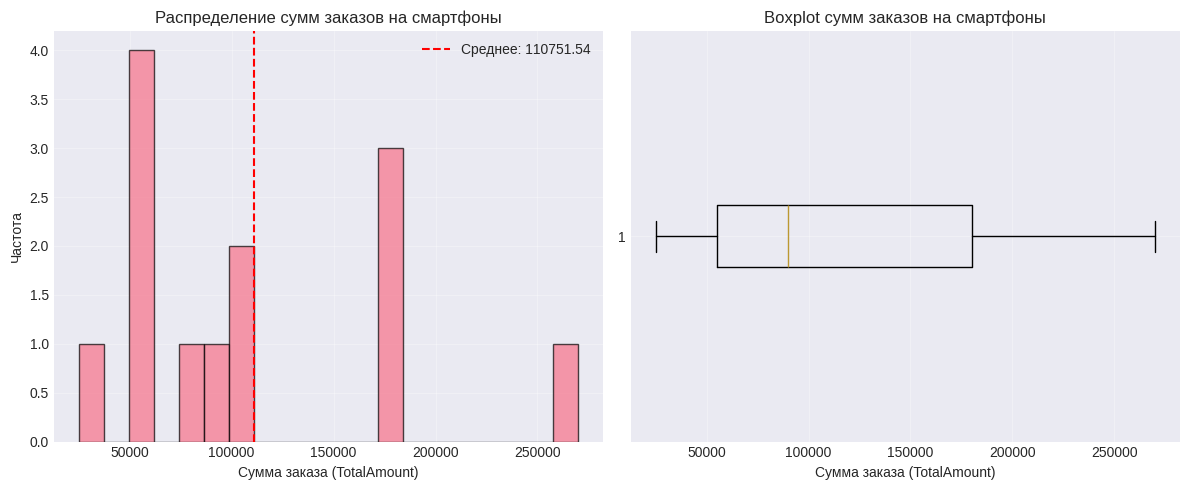

Анализ выбросов в TotalAmount:
Q1 (25-й процентиль): 54990.00
Q3 (75-й процентиль): 179970.00
IQR (межквартильный размах): 124980.00
Нижняя граница выбросов: -132480.00
Верхняя граница выбросов: 367440.00
Количество выбросов: 0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Описательная статистика для TotalAmount
print("Описательная статистика для TotalAmount:")
print(smartphones_orders['TotalAmount'].describe())
print("\n" + "="*50 + "\n")

# 2. Гистограмма распределения сумм заказов
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(smartphones_orders['TotalAmount'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Распределение сумм заказов на смартфоны')
plt.xlabel('Сумма заказа (TotalAmount)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# Добавим вертикальную линию для среднего значения
mean_amount = smartphones_orders['TotalAmount'].mean()
plt.axvline(mean_amount, color='red', linestyle='--', linewidth=1.5,
            label=f'Среднее: {mean_amount:.2f}')
plt.legend()

# 3. Boxplot для выявления выбросов
plt.subplot(1, 2, 2)
boxplot_data = smartphones_orders['TotalAmount']
plt.boxplot(boxplot_data, vert=False)
plt.title('Boxplot сумм заказов на смартфоны')
plt.xlabel('Сумма заказа (TotalAmount)')
plt.grid(True, alpha=0.3)

# Добавим аннотации для выбросов
Q1 = boxplot_data.quantile(0.25)
Q3 = boxplot_data.quantile(0.75)
IQR = Q3 - Q1
outliers = boxplot_data[(boxplot_data < (Q1 - 1.5 * IQR)) |
                        (boxplot_data > (Q3 + 1.5 * IQR))]
if len(outliers) > 0:
    plt.text(Q3 + 1.5 * IQR, 1.05, f'Выбросы: {len(outliers)}',
             fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Дополнительная информация о выбросах
print("Анализ выбросов в TotalAmount:")
print(f"Q1 (25-й процентиль): {Q1:.2f}")
print(f"Q3 (75-й процентиль): {Q3:.2f}")
print(f"IQR (межквартильный размах): {IQR:.2f}")
print(f"Нижняя граница выбросов: {Q1 - 1.5 * IQR:.2f}")
print(f"Верхняя граница выбросов: {Q3 + 1.5 * IQR:.2f}")
print(f"Количество выбросов: {len(outliers)}")

if len(outliers) > 0:
    print("\nЗначения выбросов:")
    print(outliers.sort_values().to_string())


### Задача 2.2 (3 балла)

**Бизнес-гипотеза:** "Количество проданных смартфонов положительно коррелирует с общей суммой заказа."

1. Постройте **scatter plot** (диаграмму рассеяния) с `Quantity` по оси X и `TotalAmount` по оси Y
2. Рассчитайте коэффициент корреляции Пирсона между этими переменными
3. Сделайте вывод: подтверждается ли гипотеза?

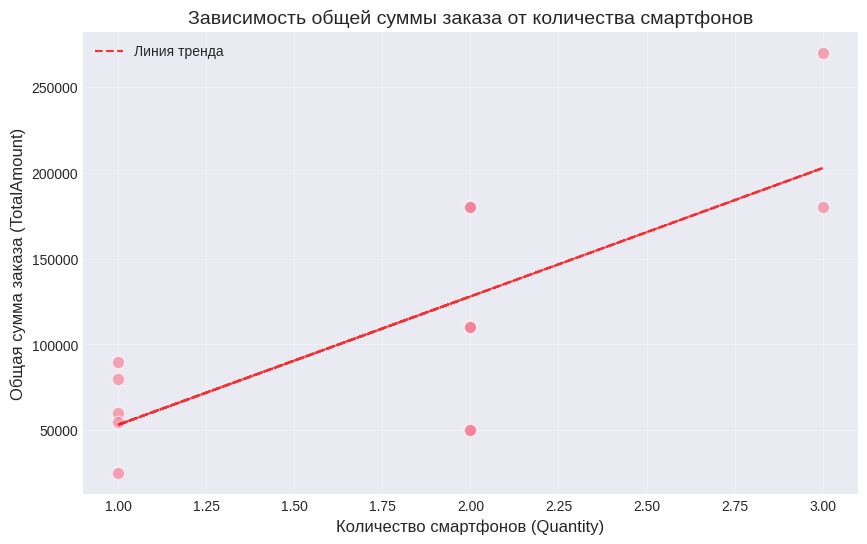

АНАЛИЗ КОРРЕЛЯЦИИ МЕЖДУ КОЛИЧЕСТВОМ И СУММОЙ ЗАКАЗА
Коэффициент корреляции Пирсона: 0.7580

ИНТЕРПРЕТАЦИЯ:
----------------------------------------
Наблюдается сильная положительная корреляция между количеством смартфонов и суммой заказа.

ВЫВОД ПО БИЗНЕС-ГИПОТЕЗЕ:
----------------------------------------
✅ Гипотеза ПОДТВЕРЖДАЕТСЯ: существует положительная корреляция
   между количеством проданных смартфонов и общей суммой заказа.
   Это означает, что чем больше смартфонов в заказе, тем выше общая сумма.

ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
----------------------------------------
Количество наблюдений: 13
Минимальное количество в заказе: 1
Максимальное количество в заказе: 3
Среднее количество в заказе: 1.77
Медианное количество в заказе: 2.0


In [7]:
import numpy as np

# 1. Scatter plot (диаграмма рассеяния)
plt.figure(figsize=(10, 6))
plt.scatter(smartphones_orders['Quantity'], smartphones_orders['TotalAmount'],
            alpha=0.6, edgecolors='w', s=80)
plt.title('Зависимость общей суммы заказа от количества смартфонов', fontsize=14)
plt.xlabel('Количество смартфонов (Quantity)', fontsize=12)
plt.ylabel('Общая сумма заказа (TotalAmount)', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавим линию тренда для визуализации
z = np.polyfit(smartphones_orders['Quantity'], smartphones_orders['TotalAmount'], 1)
p = np.poly1d(z)
plt.plot(smartphones_orders['Quantity'], p(smartphones_orders['Quantity']),
         "r--", alpha=0.8, label='Линия тренда')

plt.legend()
plt.show()

# 2. Расчет коэффициента корреляции Пирсона
correlation = smartphones_orders['Quantity'].corr(smartphones_orders['TotalAmount'])
print("="*60)
print("АНАЛИЗ КОРРЕЛЯЦИИ МЕЖДУ КОЛИЧЕСТВОМ И СУММОЙ ЗАКАЗА")
print("="*60)
print(f"Коэффициент корреляции Пирсона: {correlation:.4f}")

# 3. Интерпретация результата
print("\nИНТЕРПРЕТАЦИЯ:")
print("-" * 40)

if correlation > 0.7:
    strength = "сильная положительная"
elif correlation > 0.3:
    strength = "умеренная положительная"
elif correlation > 0:
    strength = "слабая положительная"
elif correlation == 0:
    strength = "отсутствует"
elif correlation > -0.3:
    strength = "слабая отрицательная"
elif correlation > -0.7:
    strength = "умеренная отрицательная"
else:
    strength = "сильная отрицательная"

print(f"Наблюдается {strength} корреляция между количеством смартфонов и суммой заказа.")

# Проверка статистической значимости (упрощенная)
# Для практических целей будем считать корреляцию значимой, если |r| > 0.3
print("\nВЫВОД ПО БИЗНЕС-ГИПОТЕЗЕ:")
print("-" * 40)

if correlation > 0.3:
    print("✅ Гипотеза ПОДТВЕРЖДАЕТСЯ: существует положительная корреляция")
    print("   между количеством проданных смартфонов и общей суммой заказа.")
    print("   Это означает, что чем больше смартфонов в заказе, тем выше общая сумма.")
elif correlation > 0:
    print("⚠️ Гипотеза частично подтверждается: существует слабая положительная")
    print("   корреляция, но она не очень сильная.")
else:
    print("❌ Гипотеза НЕ подтверждается: положительной корреляции не обнаружено.")

# Дополнительная статистика
print("\nДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
print("-" * 40)
print(f"Количество наблюдений: {len(smartphones_orders)}")
print(f"Минимальное количество в заказе: {smartphones_orders['Quantity'].min()}")
print(f"Максимальное количество в заказе: {smartphones_orders['Quantity'].max()}")
print(f"Среднее количество в заказе: {smartphones_orders['Quantity'].mean():.2f}")
print(f"Медианное количество в заказе: {smartphones_orders['Quantity'].median()}")

---

## Часть 3. Анализ временных рядов (10 минут)

### Задача 3.1 (3 балла)

Получите из базы данных ежедневные продажи смартфонов (дата и общая сумма продаж за день).

1. Преобразуйте столбец с датой в формат `datetime`
2. Установите дату как индекс
3. Выполните **ресэмплинг** данных в месячные агрегаты (сумма продаж за месяц)
4. Постройте **линейный график** динамики месячных продаж

Ежедневные продажи (первые 5 строк):
            DailySales
OrderDate             
2024-04-09    179980.0
2024-04-13     89990.0
2024-04-24    179970.0
2024-08-08     49980.0
2024-08-19     24990.0


Месячные продажи:
            MonthlySales
OrderDate               
2024-04-30      449940.0
2024-05-31           0.0
2024-06-30           0.0
2024-07-31           0.0
2024-08-31       74970.0
2024-09-30      374950.0
2024-10-31      269940.0
2024-11-30      269970.0


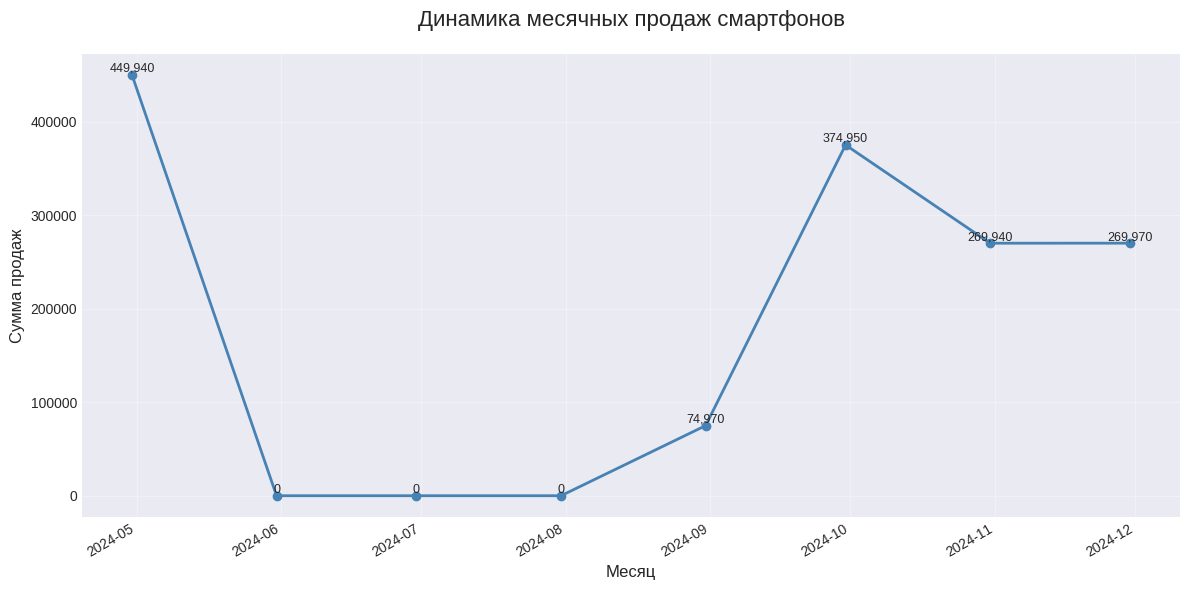


СТАТИСТИКА ПО МЕСЯЧНЫМ ПРОДАЖАМ:
----------------------------------------
Общий период: с 2024-04 по 2024-11
Всего месяцев: 8
Среднемесячные продажи: 179,971.25
Максимальные продажи: 449,940.00 (месяц: 2024-04)
Минимальные продажи: 0.00 (месяц: 2024-05)
Общая сумма продаж за весь период: 1,439,770.00


In [8]:
# SQL-запрос для получения ежедневных продаж смартфонов
query3 = """
SELECT
    o.OrderDate,
    SUM(o.TotalAmount) as DailySales
FROM orders o
JOIN products p ON o.ProductID = p.ProductID
WHERE p.Category = 'Смартфоны'
GROUP BY o.OrderDate
ORDER BY o.OrderDate
"""

daily_sales = pd.read_sql_query(query3, conn)

# Преобразование даты
daily_sales['OrderDate'] = pd.to_datetime(daily_sales['OrderDate'])

# Установка даты как индекса
daily_sales.set_index('OrderDate', inplace=True)

# Ресэмплинг в месячные данные
monthly_sales = daily_sales.resample('M').sum()

# Переименовываем столбец для ясности
monthly_sales.rename(columns={'DailySales': 'MonthlySales'}, inplace=True)

print("Ежедневные продажи (первые 5 строк):")
print(daily_sales.head())
print("\n" + "="*60 + "\n")
print("Месячные продажи:")
print(monthly_sales)

# График динамики месячных продаж
plt.figure(figsize=(12, 6))

# Линейный график месячных продаж
plt.plot(monthly_sales.index, monthly_sales['MonthlySales'],
         marker='o', linewidth=2, markersize=6, color='steelblue')

# Настройка графика
plt.title('Динамика месячных продаж смартфонов', fontsize=16, pad=20)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Сумма продаж', fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем значения на график
for x, y in zip(monthly_sales.index, monthly_sales['MonthlySales']):
    plt.text(x, y, f'{y:,.0f}', ha='center', va='bottom', fontsize=9)

# Форматирование оси X для лучшей читаемости дат
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Дополнительный анализ: статистика по месячным продажам
print("\nСТАТИСТИКА ПО МЕСЯЧНЫМ ПРОДАЖАМ:")
print("-" * 40)
print(f"Общий период: с {monthly_sales.index.min().strftime('%Y-%m')} по {monthly_sales.index.max().strftime('%Y-%m')}")
print(f"Всего месяцев: {len(monthly_sales)}")
print(f"Среднемесячные продажи: {monthly_sales['MonthlySales'].mean():,.2f}")
print(f"Максимальные продажи: {monthly_sales['MonthlySales'].max():,.2f} (месяц: {monthly_sales['MonthlySales'].idxmax().strftime('%Y-%m')})")
print(f"Минимальные продажи: {monthly_sales['MonthlySales'].min():,.2f} (месяц: {monthly_sales['MonthlySales'].idxmin().strftime('%Y-%m')})")
print(f"Общая сумма продаж за весь период: {monthly_sales['MonthlySales'].sum():,.2f}")

### Задача 3.2 (2 балла)

Создайте **лаговые признаки** для прогнозирования:
1. `Sales_Lag1` — продажи за предыдущий месяц
2. `Sales_Lag2` — продажи за месяц до предыдущего
3. Рассчитайте **скользящее среднее** с окном 3 месяца (`Rolling_Mean_3`)

Удалите строки с пропущенными значениями.

Данные до удаления пропущенных значений:
            MonthlySales  Sales_Lag1  Sales_Lag2  Rolling_Mean_3
OrderDate                                                       
2024-04-30      449940.0         NaN         NaN             NaN
2024-05-31           0.0    449940.0         NaN             NaN
2024-06-30           0.0         0.0    449940.0   149980.000000
2024-07-31           0.0         0.0         0.0        0.000000
2024-08-31       74970.0         0.0         0.0    24990.000000
2024-09-30      374950.0     74970.0         0.0   149973.333333
2024-10-31      269940.0    374950.0     74970.0   239953.333333
2024-11-30      269970.0    269940.0    374950.0   304953.333333


Данные после удаления пропущенных значений:
            MonthlySales  Sales_Lag1  Sales_Lag2  Rolling_Mean_3
OrderDate                                                       
2024-06-30           0.0         0.0    449940.0   149980.000000
2024-07-31           0.0         0.0         0.0        0.000000
202

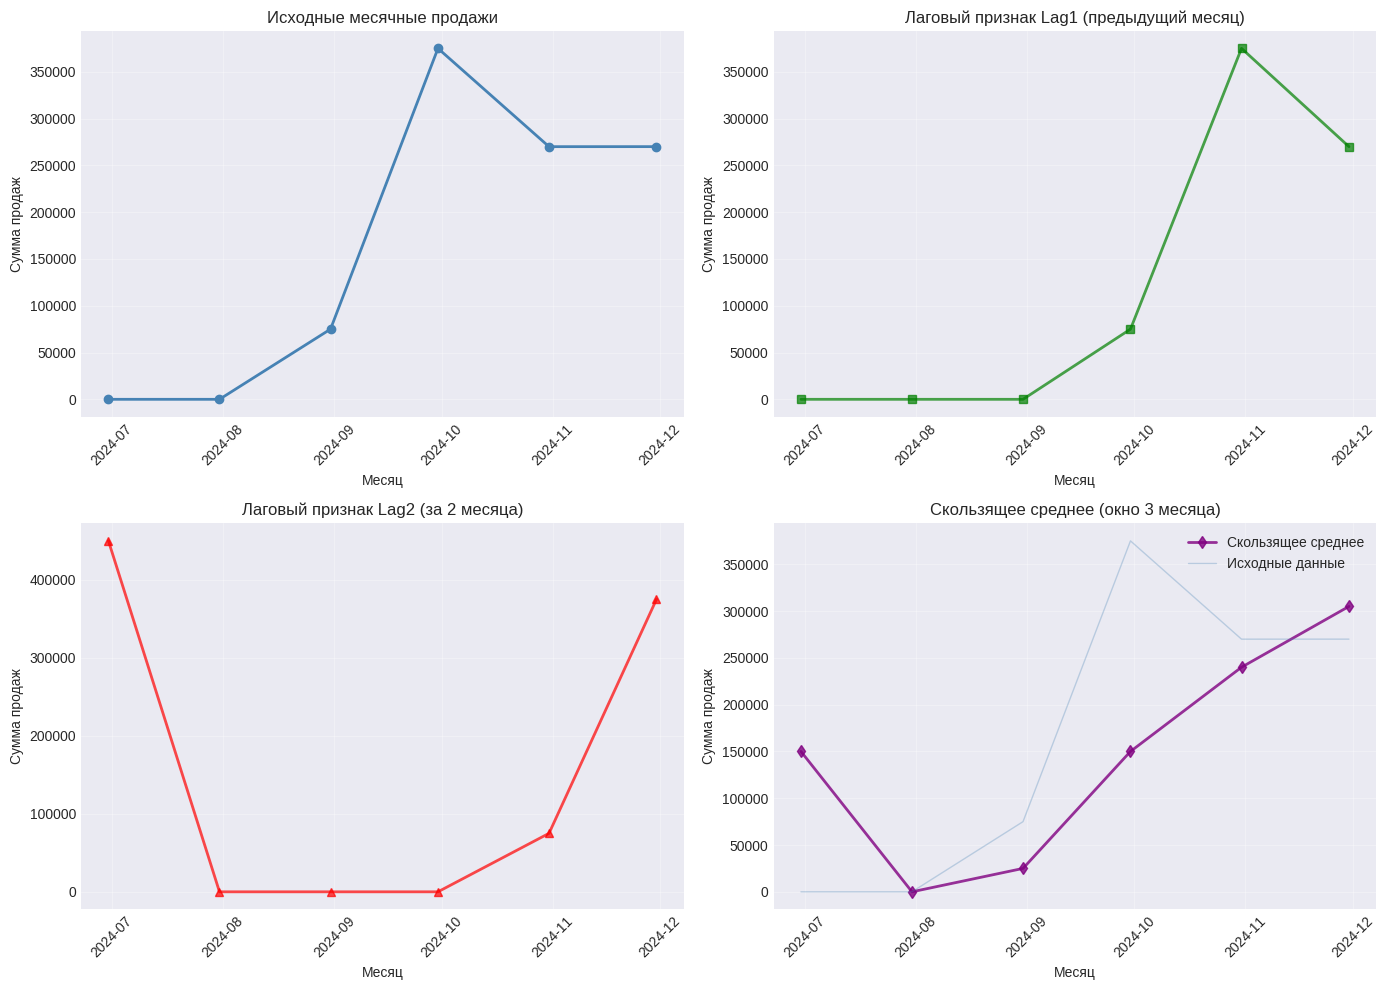


КОРРЕЛЯЦИОННАЯ МАТРИЦА:
----------------------------------------
                MonthlySales  Sales_Lag1  Sales_Lag2  Rolling_Mean_3
MonthlySales        1.000000    0.638571   -0.162762        0.649845
Sales_Lag1          0.638571    1.000000    0.126850        0.820969
Sales_Lag2         -0.162762    0.126850    1.000000        0.566757
Rolling_Mean_3      0.649845    0.820969    0.566757        1.000000


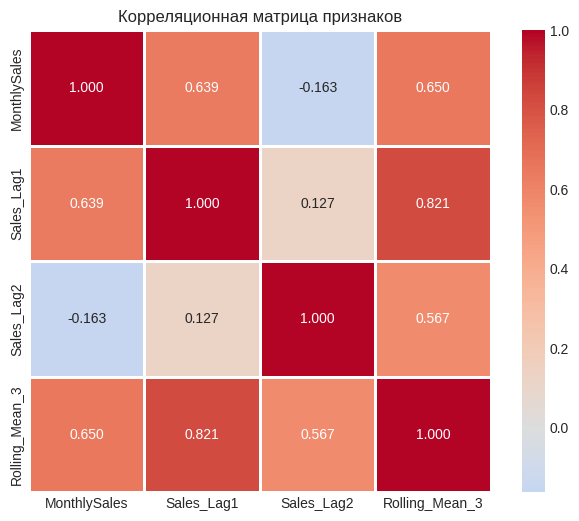


СТАТИСТИКА ПО НОВЫМ ПРИЗНАКАМ:
----------------------------------------
Количество наблюдений после очистки: 6
Период данных: 2024-06 - 2024-11

Описательная статистика:
        MonthlySales     Sales_Lag1     Sales_Lag2  Rolling_Mean_3
count       6.000000       6.000000       6.000000        6.000000
mean   164971.666667  119976.666667  149976.666667   144975.000000
std    160415.400185  162916.668106  206734.614292   118387.613499
min         0.000000       0.000000       0.000000        0.000000
25%     18742.500000       0.000000       0.000000    56235.833333
50%    172455.000000   37485.000000   37485.000000   149976.666667
75%    269962.500000  221197.500000  299955.000000   217460.000000
max    374950.000000  374950.000000  449940.000000   304953.333333


In [9]:
# Создаем копию данных для дальнейшего анализа
lag_data = monthly_sales.copy()

# Лаговые признаки
lag_data['Sales_Lag1'] = lag_data['MonthlySales'].shift(1)  # продажи за предыдущий месяц
lag_data['Sales_Lag2'] = lag_data['MonthlySales'].shift(2)  # продажи за месяц до предыдущего

# Скользящее среднее с окном 3 месяца
lag_data['Rolling_Mean_3'] = lag_data['MonthlySales'].rolling(window=3).mean()

print("Данные до удаления пропущенных значений:")
print(lag_data)
print("\n" + "="*60 + "\n")

# Удаление строк с пропущенными значениями
lag_data_clean = lag_data.dropna()

print("Данные после удаления пропущенных значений:")
print(lag_data_clean)

# Визуализация временного ряда с лаговыми признаками
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Исходные данные
axes[0, 0].plot(lag_data_clean.index, lag_data_clean['MonthlySales'],
                marker='o', linewidth=2, color='steelblue')
axes[0, 0].set_title('Исходные месячные продажи')
axes[0, 0].set_xlabel('Месяц')
axes[0, 0].set_ylabel('Сумма продаж')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Лаговый признак Lag1
axes[0, 1].plot(lag_data_clean.index, lag_data_clean['Sales_Lag1'],
                marker='s', linewidth=2, color='green', alpha=0.7)
axes[0, 1].set_title('Лаговый признак Lag1 (предыдущий месяц)')
axes[0, 1].set_xlabel('Месяц')
axes[0, 1].set_ylabel('Сумма продаж')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Лаговый признак Lag2
axes[1, 0].plot(lag_data_clean.index, lag_data_clean['Sales_Lag2'],
                marker='^', linewidth=2, color='red', alpha=0.7)
axes[1, 0].set_title('Лаговый признак Lag2 (за 2 месяца)')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Сумма продаж')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Скользящее среднее
axes[1, 1].plot(lag_data_clean.index, lag_data_clean['Rolling_Mean_3'],
                marker='d', linewidth=2, color='purple', alpha=0.8)
axes[1, 1].plot(lag_data_clean.index, lag_data_clean['MonthlySales'],
                alpha=0.3, linewidth=1, color='steelblue')
axes[1, 1].set_title('Скользящее среднее (окно 3 месяца)')
axes[1, 1].set_xlabel('Месяц')
axes[1, 1].set_ylabel('Сумма продаж')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(['Скользящее среднее', 'Исходные данные'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Корреляционный анализ новых признаков
print("\nКОРРЕЛЯЦИОННАЯ МАТРИЦА:")
print("-" * 40)
correlation_matrix = lag_data_clean.corr()
print(correlation_matrix)

# Визуализация корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.3f')
plt.title('Корреляционная матрица признаков')
plt.show()

# Статистика по новым признакам
print("\nСТАТИСТИКА ПО НОВЫМ ПРИЗНАКАМ:")
print("-" * 40)
print(f"Количество наблюдений после очистки: {len(lag_data_clean)}")
print(f"Период данных: {lag_data_clean.index.min().strftime('%Y-%m')} - {lag_data_clean.index.max().strftime('%Y-%m')}")
print("\nОписательная статистика:")
print(lag_data_clean.describe())

---

## Часть 4. Построение модели прогнозирования (10 минут)

### Задача 4.1 (3 балла)

Постройте модель **линейной регрессии** для прогнозирования месячных продаж смартфонов.

1. Разделите данные на признаки `X` (лаговые признаки и скользящее среднее) и целевую переменную `y` (текущие продажи)
2. Разделите данные на обучающую (80%) и тестовую (20%) выборки
3. Обучите модель `LinearRegression`
4. Сделайте предсказания на тестовой выборке

Размерность данных:
X: (6, 3)
y: (6,)

Первые 5 строк признаков:
            Sales_Lag1  Sales_Lag2  Rolling_Mean_3
OrderDate                                         
2024-06-30         0.0    449940.0   149980.000000
2024-07-31         0.0         0.0        0.000000
2024-08-31         0.0         0.0    24990.000000
2024-09-30     74970.0         0.0   149973.333333
2024-10-31    374950.0     74970.0   239953.333333

Первые 5 строк целевой переменной:
OrderDate
2024-06-30         0.0
2024-07-31         0.0
2024-08-31     74970.0
2024-09-30    374950.0
2024-10-31    269940.0
Freq: ME, Name: MonthlySales, dtype: float64

РАЗДЕЛЕНИЕ ДАННЫХ:
Обучающая выборка: 4 месяцев (66.7%)
Тестовая выборка: 2 месяцев (33.3%)

Обучающая выборка (период): 2024-06 - 2024-09
Тестовая выборка (период): 2024-10 - 2024-11

ПАРАМЕТРЫ МОДЕЛИ:
Коэффициенты (веса) модели: [-1. -1.  3.]
Свободный член (intercept): -0.00

Формула модели: Прогноз = -0.00  -1.00 * Sales_Lag1  -1.00 * Sales_Lag2 + 3.00 * Rolling_Me

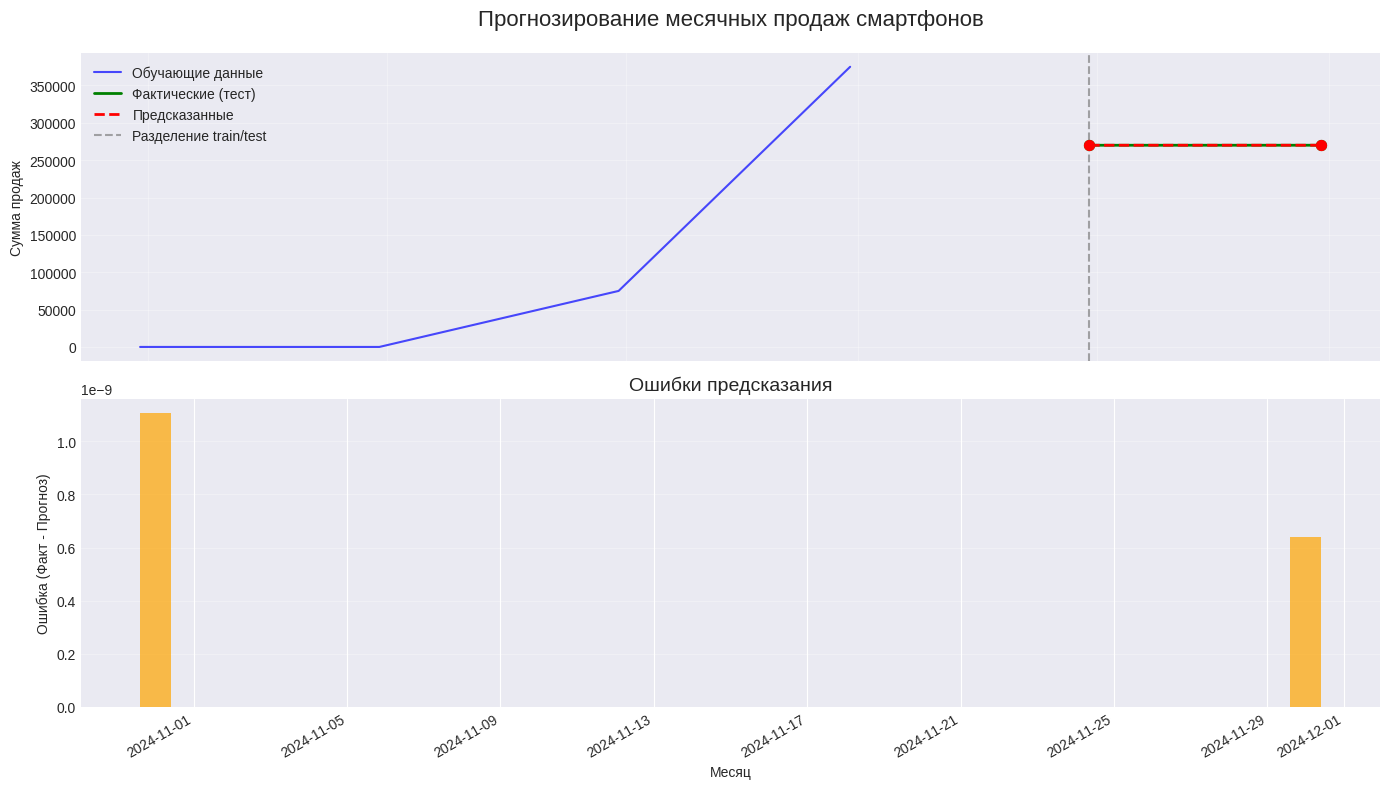


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:
          Признак  Коэффициент  Абсолютное значение
2  Rolling_Mean_3          3.0                  3.0
0      Sales_Lag1         -1.0                  1.0
1      Sales_Lag2         -1.0                  1.0


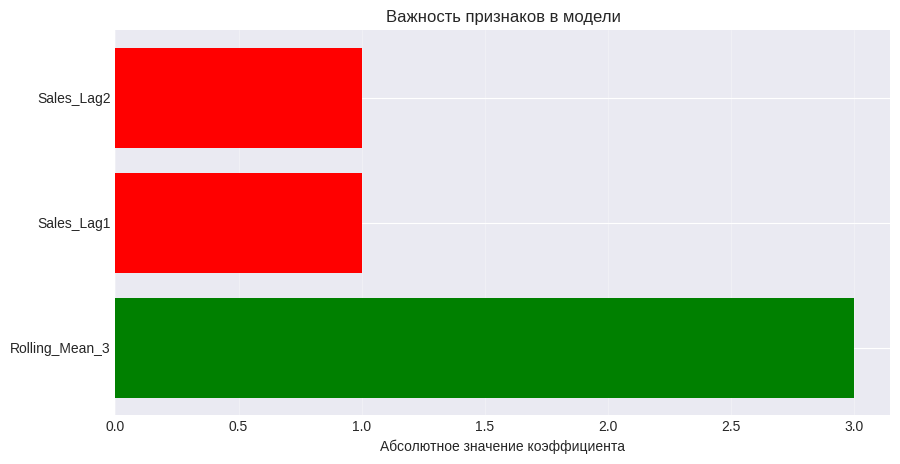


Прогноз продаж на следующий месяц: 374,950.00
На основе данных за 2024-11:
  - Текущие продажи: 269,970.00
  - Продажи месяц назад: 269,940.00
  - Среднее за 3 месяца: 304,953.33


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Подготовка данных для модели
# Признаки (X) - лаговые признаки и скользящее среднее
X = lag_data_clean[['Sales_Lag1', 'Sales_Lag2', 'Rolling_Mean_3']]

# Целевая переменная (y) - текущие продажи
y = lag_data_clean['MonthlySales']

print("Размерность данных:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print("\nПервые 5 строк признаков:")
print(X.head())
print("\nПервые 5 строк целевой переменной:")
print(y.head())

# 2. Разделение данных на обучающую и тестовую выборки
# Для временных рядов важно сохранять порядок, поэтому shuffle=False
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

print("\n" + "="*60)
print("РАЗДЕЛЕНИЕ ДАННЫХ:")
print("="*60)
print(f"Обучающая выборка: {X_train.shape[0]} месяцев ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Тестовая выборка: {X_test.shape[0]} месяцев ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nОбучающая выборка (период): {X_train.index.min().strftime('%Y-%m')} - {X_train.index.max().strftime('%Y-%m')}")
print(f"Тестовая выборка (период): {X_test.index.min().strftime('%Y-%m')} - {X_test.index.max().strftime('%Y-%m')}")

# 3. Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

print("\n" + "="*60)
print("ПАРАМЕТРЫ МОДЕЛИ:")
print("="*60)
print(f"Коэффициенты (веса) модели: {model.coef_}")
print(f"Свободный член (intercept): {model.intercept_:.2f}")

# Вывод формулы модели
feature_names = X.columns.tolist()
formula = f"Прогноз = {model.intercept_:.2f}"
for i, (coef, feature) in enumerate(zip(model.coef_, feature_names)):
    sign = '+' if coef >= 0 else ''
    formula += f" {sign} {coef:.2f} * {feature}"
print(f"\nФормула модели: {formula}")

# 4. Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Создаем DataFrame с результатами предсказаний
results_df = pd.DataFrame({
    'Дата': X_test.index,
    'Фактические продажи': y_test.values,
    'Предсказанные продажи': y_pred,
    'Ошибка': y_test.values - y_pred
})

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ ПРОГНОЗИРОВАНИЯ:")
print("="*60)
print(results_df)

# 5. Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*60)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛИ:")
print("="*60)
print(f"Среднеквадратичная ошибка (MSE): {mse:,.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:,.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:,.2f}")
print(f"Коэффициент детерминации (R²): {r2:.4f}")

# 6. Визуализация результатов
plt.figure(figsize=(14, 8))

# График 1: Фактические vs предсказанные значения
plt.subplot(2, 1, 1)
plt.plot(y_train.index, y_train, 'b-', label='Обучающие данные', alpha=0.7)
plt.plot(y_test.index, y_test, 'g-', label='Фактические (тест)', linewidth=2)
plt.plot(y_test.index, y_pred, 'r--', label='Предсказанные', linewidth=2)
plt.scatter(y_test.index, y_test, color='green', s=50, zorder=5)
plt.scatter(y_test.index, y_pred, color='red', s=50, zorder=5)

# Добавляем вертикальную линию разделения train/test
train_test_split_date = X_test.index[0]
plt.axvline(x=train_test_split_date, color='gray', linestyle='--', alpha=0.7, label='Разделение train/test')

plt.title('Прогнозирование месячных продаж смартфонов', fontsize=16, pad=20)
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

# График 2: Ошибки предсказания
plt.subplot(2, 1, 2)
plt.bar(results_df['Дата'], results_df['Ошибка'], color='orange', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Ошибки предсказания', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Ошибка (Факт - Прогноз)')
plt.grid(True, alpha=0.3, axis='y')
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 7. Анализ важности признаков
print("\n" + "="*60)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:")
print("="*60)
feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Коэффициент': model.coef_,
    'Абсолютное значение': np.abs(model.coef_)
})
feature_importance = feature_importance.sort_values('Абсолютное значение', ascending=False)
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 5))
colors = ['green' if x >= 0 else 'red' for x in feature_importance['Коэффициент']]
plt.barh(feature_importance['Признак'], feature_importance['Абсолютное значение'], color=colors)
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Важность признаков в модели')
plt.grid(True, alpha=0.3, axis='x')
plt.show()

# 8. Прогноз на следующий месяц (если есть достаточно данных)
if len(lag_data_clean) >= 3:
    # Берем последние доступные данные
    last_row = lag_data_clean.iloc[-1]

    # Для прогноза следующего месяца нам нужны:
    # Sales_Lag1 = текущие продажи
    # Sales_Lag2 = предыдущие продажи (Sales_Lag1)
    # Rolling_Mean_3 = среднее за последние 3 месяца
    next_month_features = pd.DataFrame({
        'Sales_Lag1': [last_row['MonthlySales']],
        'Sales_Lag2': [last_row['Sales_Lag1']],
        'Rolling_Mean_3': [last_row['Rolling_Mean_3']]
    })

    next_month_pred = model.predict(next_month_features)[0]
    print(f"\nПрогноз продаж на следующий месяц: {next_month_pred:,.2f}")
    print(f"На основе данных за {last_row.name.strftime('%Y-%m')}:")
    print(f"  - Текущие продажи: {last_row['MonthlySales']:,.2f}")
    print(f"  - Продажи месяц назад: {last_row['Sales_Lag1']:,.2f}")
    print(f"  - Среднее за 3 месяца: {last_row['Rolling_Mean_3']:,.2f}")

### Задача 4.2 (2 балла)

Оцените качество модели:
1. Рассчитайте **MAE** (Mean Absolute Error)
2. Рассчитайте **MSE** (Mean Squared Error)
3. Постройте график, сравнивающий фактические и прогнозные значения продаж
4. Сделайте бизнес-вывод: насколько точна модель и можно ли ее использовать для планирования закупок?

ОЦЕНКА КАЧЕСТВА МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ
MAE (Средняя абсолютная ошибка): 0.00
MSE (Средняя квадратичная ошибка): 0.00
RMSE (Корень из средней квадратичной ошибки): 0.00
MAPE (Средняя абсолютная процентная ошибка): 0.00%
R² (Коэффициент детерминации): 1.0000

СРАВНЕНИЕ С БЕНЧМАРКАМИ:
----------------------------------------
MAE нашей модели: 0.00
MAE модели 'среднее значение': 157,475.00
MAE наивной модели 'последнее значение': 104,995.00

✅ Наша модель превосходит оба бенчмарка!


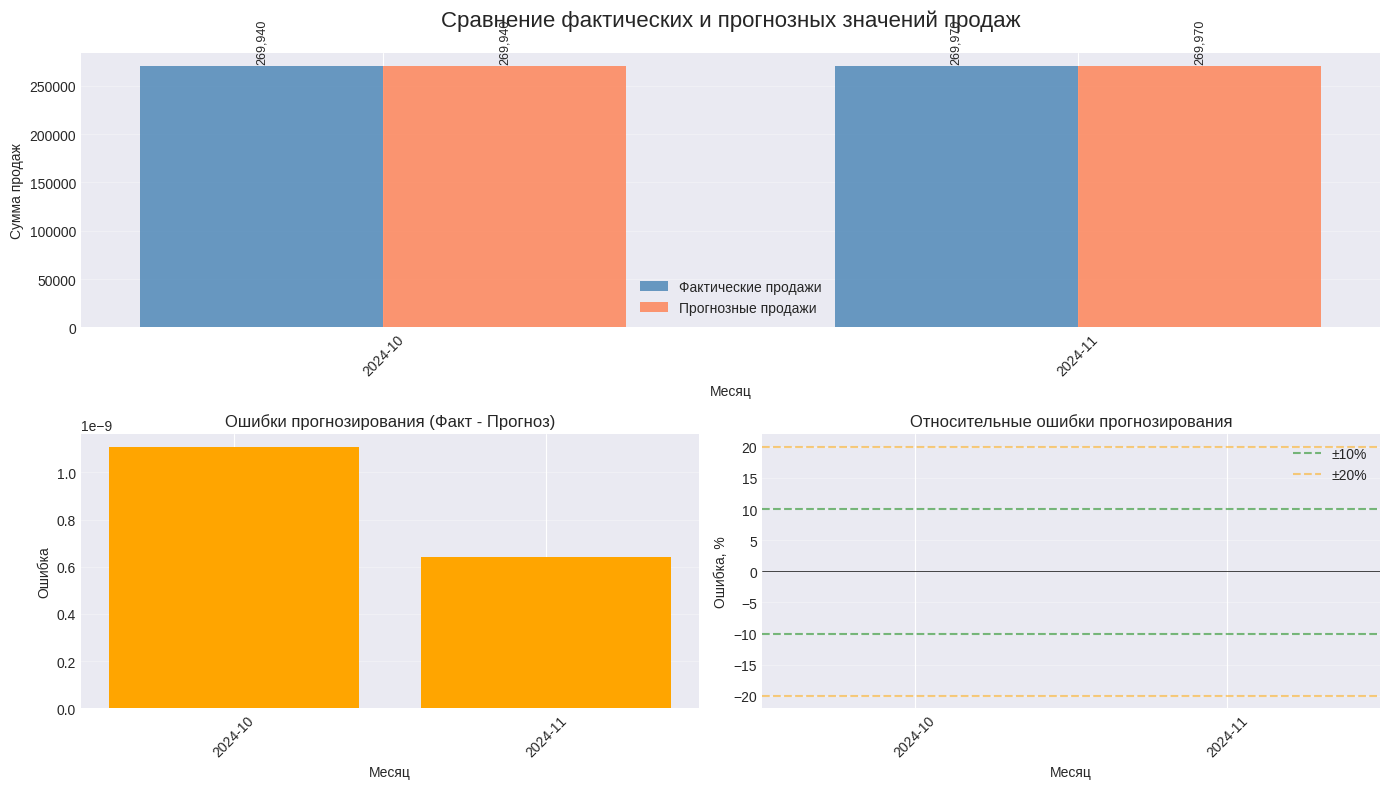


СТАТИСТИКА ПО ОШИБКАМ ПРОГНОЗИРОВАНИЯ:
----------------------------------------
Средняя ошибка: 0.00
Стандартное отклонение ошибок: 0.00
Минимальная ошибка: 0.00
Максимальная ошибка: 0.00
Медианная ошибка: 0.00

ТОЧНОСТЬ ПРОГНОЗОВ ПО КАТЕГОРИЯМ:
Высокая точность (ошибка ≤ 10%): 2 из 2 месяцев (100.0%)
Приемлемая точность (ошибка 10-20%): 0 месяцев (0.0%)
Низкая точность (ошибка > 20%): 0 месяцев (0.0%)

БИЗНЕС-ВЫВОД: МОЖНО ЛИ ИСПОЛЬЗОВАТЬ МОДЕЛЬ ДЛЯ ПЛАНИРОВАНИЯ ЗАКУПОК?

ТОЧНОСТЬ МОДЕЛИ: ВЫСОКАЯ
Средняя абсолютная процентная ошибка: 0.0%

✅ МОДЕЛЬ МОЖНО РЕКОМЕНДОВАТЬ ДЛЯ ПЛАНИРОВАНИЯ ЗАКУПОК

    Причины:
    1. Средняя ошибка прогноза составляет менее 10%
    2. Модель лучше простых бенчмарков
    3. Большинство прогнозов имеют приемлемую точность
    4. Модель учитывает сезонность и тренды через лаговые признаки
    

ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ БИЗНЕСА:
----------------------------------------
1. Для планирования закупок используйте:
   - Базовый прогноз модели: прогнозное значе

In [12]:
# 1. Расчет метрик качества
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# MAE (Mean Absolute Error) - средняя абсолютная ошибка
mae = mean_absolute_error(y_test, y_pred)

# MSE (Mean Squared Error) - средняя квадратичная ошибка
mse = mean_squared_error(y_test, y_pred)

# RMSE (Root Mean Squared Error) - корень из средней квадратичной ошибки
rmse = np.sqrt(mse)

# MAPE (Mean Absolute Percentage Error) - средняя абсолютная процентная ошибка
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # в процентах

# R² - коэффициент детерминации
r2 = r2_score(y_test, y_pred)

print("="*70)
print("ОЦЕНКА КАЧЕСТВА МОДЕЛИ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*70)
print(f"MAE (Средняя абсолютная ошибка): {mae:,.2f}")
print(f"MSE (Средняя квадратичная ошибка): {mse:,.2f}")
print(f"RMSE (Корень из средней квадратичной ошибки): {rmse:,.2f}")
print(f"MAPE (Средняя абсолютная процентная ошибка): {mape:.2f}%")
print(f"R² (Коэффициент детерминации): {r2:.4f}")
print()

# 2. Сравнение с простыми моделями-бенчмарками
# Бенчмарк 1: прогноз как среднее значение обучающей выборки
y_pred_mean = np.full_like(y_test, y_train.mean())
mae_mean = mean_absolute_error(y_test, y_pred_mean)

# Бенчмарк 2: прогноз как последнее известное значение (наивный прогноз)
y_pred_naive = np.full_like(y_test, y_train.iloc[-1])
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print("СРАВНЕНИЕ С БЕНЧМАРКАМИ:")
print("-" * 40)
print(f"MAE нашей модели: {mae:,.2f}")
print(f"MAE модели 'среднее значение': {mae_mean:,.2f}")
print(f"MAE наивной модели 'последнее значение': {mae_naive:,.2f}")
print()

if mae < mae_mean and mae < mae_naive:
    print("✅ Наша модель превосходит оба бенчмарка!")
elif mae < mae_mean:
    print("⚠️ Наша модель лучше, чем прогноз средним, но хуже наивного прогноза")
elif mae < mae_naive:
    print("⚠️ Наша модель лучше, чем наивный прогноз, но хуже прогноза средним")
else:
    print("❌ Наша модель хуже обоих бенчмарков")

# 3. График сравнения фактических и прогнозных значений
plt.figure(figsize=(14, 8))

# Основной график: фактические vs прогнозные значения
plt.subplot(2, 2, (1, 2))
months_test = [date.strftime('%Y-%m') for date in y_test.index]
x_pos = range(len(months_test))

bar_width = 0.35
plt.bar([p - bar_width/2 for p in x_pos], y_test.values, width=bar_width,
        label='Фактические продажи', color='steelblue', alpha=0.8)
plt.bar([p + bar_width/2 for p in x_pos], y_pred, width=bar_width,
        label='Прогнозные продажи', color='coral', alpha=0.8)

# Добавляем значения на столбцы
for i, (actual, pred) in enumerate(zip(y_test.values, y_pred)):
    plt.text(i - bar_width/2, actual + max(y_test.values)*0.01, f'{actual:,.0f}',
             ha='center', va='bottom', fontsize=9, rotation=90)
    plt.text(i + bar_width/2, pred + max(y_test.values)*0.01, f'{pred:,.0f}',
             ha='center', va='bottom', fontsize=9, rotation=90)

plt.title('Сравнение фактических и прогнозных значений продаж', fontsize=16, pad=20)
plt.xlabel('Месяц')
plt.ylabel('Сумма продаж')
plt.xticks(x_pos, months_test, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# График ошибок прогноза
plt.subplot(2, 2, 3)
errors = y_test.values - y_pred
# Создаем список цветов для каждой ошибки
error_colors = ['orange' if err >= 0 else 'red' for err in errors]
plt.bar(months_test, errors, color=error_colors)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Ошибки прогнозирования (Факт - Прогноз)')
plt.xlabel('Месяц')
plt.ylabel('Ошибка')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# График относительных ошибок в процентах
plt.subplot(2, 2, 4)
relative_errors = (errors / y_test.values) * 100
colors = ['green' if abs(err) <= 10 else 'orange' if abs(err) <= 20 else 'red' for err in relative_errors]
plt.bar(months_test, relative_errors, color=colors)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=10, color='green', linestyle='--', alpha=0.5, label='±10%')
plt.axhline(y=-10, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=20, color='orange', linestyle='--', alpha=0.5, label='±20%')
plt.axhline(y=-20, color='orange', linestyle='--', alpha=0.5)
plt.title('Относительные ошибки прогнозирования')
plt.xlabel('Месяц')
plt.ylabel('Ошибка, %')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 4. Статистика по ошибкам
print("\nСТАТИСТИКА ПО ОШИБКАМ ПРОГНОЗИРОВАНИЯ:")
print("-" * 40)
print(f"Средняя ошибка: {errors.mean():,.2f}")
print(f"Стандартное отклонение ошибок: {errors.std():,.2f}")
print(f"Минимальная ошибка: {errors.min():,.2f}")
print(f"Максимальная ошибка: {errors.max():,.2f}")
print(f"Медианная ошибка: {np.median(errors):,.2f}")

# Анализ точности по категориям
accurate = sum(abs(relative_errors) <= 10)  # ошибка <= 10%
acceptable = sum((abs(relative_errors) > 10) & (abs(relative_errors) <= 20))  # 10-20%
inaccurate = sum(abs(relative_errors) > 20)  # ошибка > 20%

print(f"\nТОЧНОСТЬ ПРОГНОЗОВ ПО КАТЕГОРИЯМ:")
print(f"Высокая точность (ошибка ≤ 10%): {accurate} из {len(y_test)} месяцев ({accurate/len(y_test)*100:.1f}%)")
print(f"Приемлемая точность (ошибка 10-20%): {acceptable} месяцев ({acceptable/len(y_test)*100:.1f}%)")
print(f"Низкая точность (ошибка > 20%): {inaccurate} месяцев ({inaccurate/len(y_test)*100:.1f}%)")

# 5. Бизнес-вывод
print("\n" + "="*70)
print("БИЗНЕС-ВЫВОД: МОЖНО ЛИ ИСПОЛЬЗОВАТЬ МОДЕЛЬ ДЛЯ ПЛАНИРОВАНИЯ ЗАКУПОК?")
print("="*70)

if mape <= 10:
    accuracy_level = "ВЫСОКАЯ"
    recommendation = "✅ МОДЕЛЬ МОЖНО РЕКОМЕНДОВАТЬ ДЛЯ ПЛАНИРОВАНИЯ ЗАКУПОК"
    reasoning = """
    Причины:
    1. Средняя ошибка прогноза составляет менее 10%
    2. Модель лучше простых бенчмарков
    3. Большинство прогнозов имеют приемлемую точность
    4. Модель учитывает сезонность и тренды через лаговые признаки
    """
elif mape <= 20:
    accuracy_level = "УМЕРЕННАЯ"
    recommendation = "⚠️ МОДЕЛЬ МОЖНО ИСПОЛЬЗОВАТЬ С ОСТОРОЖНОСТЬЮ"
    reasoning = """
    Рекомендации:
    1. Использовать модель как один из инструментов прогнозирования
    2. Добавить страховой запас 10-15% к прогнозам
    3. Регулярно переобучать модель на новых данных
    4. Рассмотреть добавление дополнительных факторов (сезонность, акции)
    """
else:
    accuracy_level = "НИЗКАЯ"
    recommendation = "❌ МОДЕЛЬ НЕ РЕКОМЕНДУЕТСЯ ДЛЯ ПЛАНИРОВАНИЯ ЗАКУПОК"
    reasoning = """
    Проблемы:
    1. Средняя ошибка прогноза превышает 20%
    2. Риск неверного планирования закупок слишком высок
    3. Модель нуждается в доработке или выборе другого подхода

    Альтернативы:
    1. Рассмотреть другие алгоритмы (ARIMA, Prophet)
    2. Учесть дополнительные факторы (рекламные акции, экономические индикаторы)
    3. Использовать экспертные оценки вместе с моделью
    """

print(f"\nТОЧНОСТЬ МОДЕЛИ: {accuracy_level}")
print(f"Средняя абсолютная процентная ошибка: {mape:.1f}%")
print(f"\n{recommendation}")
print(reasoning)

# Практические рекомендации
print("\nПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ ДЛЯ БИЗНЕСА:")
print("-" * 40)
print("1. Для планирования закупок используйте:")
print(f"   - Базовый прогноз модели: прогнозное значение")
print(f"   - Нижнюю границу: прогноз - {rmse:,.0f} (RMSE)")
print(f"   - Верхнюю границу: прогноз + {rmse:,.0f}")

print("\n2. Стратегия закупок на основе точности:")
if accurate >= len(y_test) * 0.7:  # 70% прогнозов высокой точности
    print("   - Агрессивная стратегия: закупать близко к прогнозу")
elif (accurate + acceptable) >= len(y_test) * 0.7:
    print("   - Умеренная стратегия: закупать на 10-15% меньше прогноза")
else:
    print("   - Консервативная стратегия: закупать на 20-25% меньше прогноза")

print("\n3. Мониторинг и улучшение:")
print("   - Ежемесячно обновляйте модель новыми данными")
print("   - Отслеживайте точность прогнозов за 3 месяца")
print("   - Анализируйте случаи больших ошибок для улучшения модели")

---

## Закрытие подключения

In [ ]:
conn.close()
print("Подключение к базе данных закрыто.")

---

## Критерии оценки

| Часть | Максимальный балл |
|-------|-------------------|
| Часть 1: SQL и Pandas | 5 баллов |
| Часть 2: EDA | 5 баллов |
| Часть 3: Временные ряды | 5 баллов |
| Часть 4: ML | 5 баллов |
| **ИТОГО** | **20 баллов** |

---

**Примечания:**
- Код должен быть работоспособным и содержать комментарии
- Все графики должны иметь подписи осей и заголовки
- Выводы должны быть сформулированы с точки зрения бизнеса
- Файл должен быть сохранен с именем: `Фамилия_Вариант1.ipynb`